# Reliable Classification

In [2]:
import numpy as np

from matplotlib import pyplot as plt

plt.style.use('seaborn-whitegrid')

<div align="justify">

To the best of our knowledge, {cite:t}`mpub272` were the first to explicitly motivate the distinction between aleatoric and epistemic uncertainty in a machine learning context. Their approach leverages the concept of *normalized likelihood*\mmp{normalized likelihood} (cf.\ Section~\ref{sec:dos}). Moreover, it combines set-based and distributional (probabilistic) inference, and thus can be positioned in-between version space learning and Bayesian inference as discussed in Section \ref{sec:sbvd}. Since the approach contains concepts that might be less known to a machine learning audience, our description is a bit more detailed than for the other methods discussed in this section. 


Consider the simplest case of binary classification with classes $\set{Y} := \{-1, +1\}$, which suffices to explain the basic idea (and which has been generalized to the multi-class case by {cite:t}`mpub385`). {cite:t}`mpub272` focus on predictive uncertainty and derive degrees of uncertainty in a prediction in two steps, which we are going to discuss in turn:

- First, given a query instance $\vec{x}_q$, a degree of "plausibility" is derived for each candidate outcome $y \in \set{Y}$. These are degrees in the unit interval, but no probabilities. As they are not constrained by a total mass of 1, they are more apt at capturing a lack of knowledge, and hence epistemic uncertainty (cf.\ Section \ref{sec:rlk}).
- Second, degrees of aleatoric and epistemic uncertainty are derived from the degrees of plausibility.

</div>


## Modelling the plausibility of predictions

Recall that, in version space learning, the plausibility of both hypotheses and outcomes are expressed in a purely bivalent way: according to ({eq}`ee1`), a hypotheses is either considered possible/plausible or not ($\llbracket h \in \mathcal{V} \rrbracket$), and an outcome $y$ is either supported or not ($\llbracket h(\vec{x}) = y \rrbracket$). {cite:t}`mpub272` generalize both parts of the prediction from bivalent to *graded* plausibility and support: A hypothesis $h \in \cH$ has a degree of plausibility $\pi_{\cH}(h) \in [0,1]$, and the support of outcomes $y$ is expressed in terms of probabilities $h(\vec{x}) = \prob(y \given \vec{x}) \in [0,1]$.  

### Normalized likelihood

More specifically, referring to the notion of \emph{normalized likelihood}\mmp{normalized likelihood}, 
a plausibility distribution on $\cH$ (i.e., a plausibility for each hypothesis $h \in \cH$) is defined as follows:
\begin{equation}
\pi_{\cH}(h) := \frac{L(h)}{\sup_{h' \in \cH} L(h')}  = \frac{L(h)}{L(h^{ml})} \enspace ,
\end{equation}(noli)
where $L(h)$ is the likelihood of the hypothesis $h$ on the data $\set{D}$ (i.e., the probability of $\set{D}$ under this hypothesis), and $h^{ml} \in \cH$ is the maximum likelihood (ML) estimation. Thus, the plausibility of a hypothesis is in proportion to its likelihood\footnote{In principle, the same idea can of course also be applied in Bayesian inference, namely by defining plausibility in terms of a normalized posterior distribution.}, with the ML estimate having the highest plausibility of 1.

For illustration we use a simple biased coin flipping example, whith probability $\theta$ head will be drawn ($1$) with probability ($1 - \theta$) tails ($0$). We denote by $n$ the number of heads in the data and by $m$ the number of tails. To avoid numerical problems we use the log likelihood which is then given by:
\begin{equation}
	log L(\theta) = \sum_{i=1}^{N}log(P(X_{i}|\theta)) = n*log(\theta) + m*log(1-\theta)
\end{equation}

The likelihood maximizer is then simply given by the share of heads in the data: $\hat{\theta}=\frac{n}{n + m}$


In [3]:
# generate random data
theta = .2
N = 10000
data = np.random.binomial(1, theta, 10000)

In [8]:
# computes the likelihood for a given theta
def log_likelihood(data, theta):
	n = np.sum(data == 1)
	m = len(data) - n
	ll = n*np.log(theta +1e-9) + m *np.log(1-theta+1e-9)

	return ll

# computes the normalized log likelihood L(h) / L(h_ml)
def norm_log_likelihood(data, theta):

	ll = log_likelihood(data, theta)
	ll_ml = log_likelihood(data, np.mean(data))

	norm_ll = np.exp(ll - ll_ml)

	return norm_ll

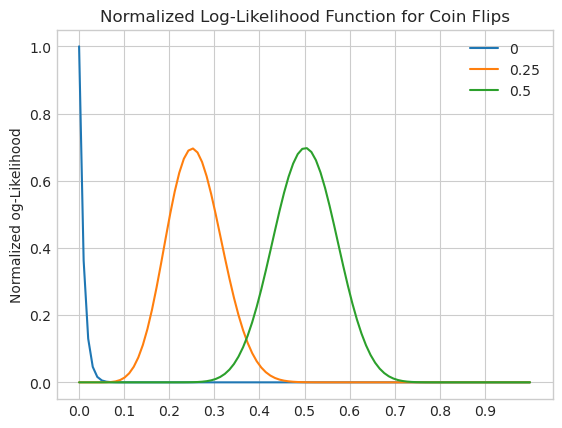

In [65]:
h_theta = np.linspace(0.0, 1.0, 100)
n_repetitions = 1000

fig, ax = plt.subplots()

for theta in [0, 0.25, 0.5]:

	result = np.zeros_like(h_theta)

	for i in range(n_repetitions):
		data = np.random.binomial(1, theta, 100)
		norm_likelihood = norm_log_likelihood(data, h_theta)
		result += norm_likelihood

	ax.plot(h_theta, result / n_repetitions, label=theta)

plt.xticks(np.arange(10) / 10)
plt.ylabel('Normalized og-Likelihood')
plt.title('Normalized Log-Likelihood Function for Coin Flips')
plt.legend()
plt.show()

The second step, both in version space and Bayesian learning, consists of translating uncertainty on $\cH$ into uncertainty about the prediction for a query $\vec{x}_q$. To this end, all predictions $h(\vec{x}_{q})$ need to be aggregated, taking into account the plausibility of the hypotheses $h \in \cH$. Due to the problems of the averaging approach (\ref{eq:pd}) in Bayesian inference, a generalization of the existential aggregation ({eq}`ee1`) used in version space learning is adopted:  
\begin{equation}
\pi(+1 \given \vec{x}_{q}) := \sup_{h \in \cH} \min\big( 
\pi_{\cH}(h) , \pi(+1 \given h, \vec{x}_{q}) \big) ,
\end{equation}(plaus)
where $\pi(+1 \given h, \vec{x}_{q})$ is the \emph{degree of support} of the positive class provided by $h$\footnote{Indeed, $\pi(\cdot \given h, \vec{x}_{q})$ should not be interpreted as a measure of uncertainty.}. This measure of support, which generalizes the all-or-nothing support $\llbracket h(\vec{x}) = y \rrbracket$ in ({eq}`ee1`), is defined as follows: 
\begin{equation}
\pi(+1 \given h, \vec{x}_{q}) := \max \big(2 h(\vec{x}_{q})-1, 0 \big)
\end{equation}(supp)
Thus, the support is 0 as long as the probability predicted by $h$ is $\leq 1/2$, and linearly increases afterward, reaching 1 for $h(\vec{x}_{q})=1$. Recalling that $h$ is a probabilistic classifier, this clearly makes sense, since values $h(\vec{x}_{q}) \leq 1/2$ are actually more in favor of the negative class, and therefore no evidence for the positive class. Also, as will be seen further below, this definition assures a maximal degree of aleatoric uncertainty in the case of full certainty about the uniform distribution $h_{1/2}$, wich is a desirable property. 
Since the supremum operator in (\ref{eq:plaus}) can be seen as a generalized existential quantifier, the expression (\ref{eq:plaus}) can be read as follows: The class $+1$ is plausible insofar there exists a hypothesis $h$ that is plausible and that strongly supports $+1$. Analogously, the plausibility for $-1$ is defined as follows:
\begin{equation}
\pi(-1 \given \vec{x}_{q}) \defeq \sup_{h \in \cH} \min\big( 
\pi_{\cH}(h) , \pi(-1 \given h, \vec{x}_{q}) \big) ,
\end{equation}(plausminus)
with $\pi(-1 \given h, \vec{x}_{q}) = \max(1 - 2 h(\vec{x}_{q}), 0)$.
An illustration of this kind of ``max-min inference'' and a discussion of how it relates to Bayesian inference (based on ``sum-product aggregation'') can be found in Appendix \ref{sec:maxmin} in the supplementary material.

In [89]:
def get_plausability(data):

	if len(data) == 0:
		return 1
	h_theta = np.linspace(0.0, 1.0, 100)
	norm_likelihood = norm_log_likelihood(data, h_theta)

	support_pos = np.max(np.vstack([2*h_theta -1, np.zeros_like(h_theta)]), axis=0)
	support_neg = np.max(np.vstack([1 - 2*(h_theta), np.zeros_like(h_theta)]), axis=0)

	pl_pos = np.max(np.min(np.vstack([norm_likelihood, support_pos]), axis=0))
	pl_neg = np.max(np.min(np.vstack([norm_likelihood, support_neg]), axis=0))

	return pl_pos, pl_neg

In [90]:
get_plausability(data)

(0.0251792349115594, 0.36619809307971224)

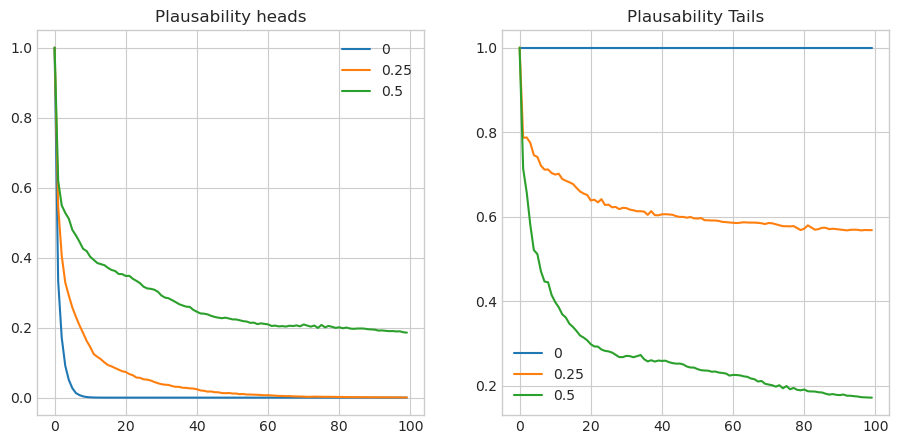

In [94]:
h_theta = np.linspace(0.0, 1.0, 100)
n_repetitions = 100
N = 100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

for theta in [0, 0.25, 0.5]:

	result = np.zeros((n_repetitions, 2, N))

	for i in range(n_repetitions):
		data = np.random.binomial(1, theta, N)
		

		for j in range(N):
			result[i, :, j] = get_plausability(data[:j])

	result = np.mean(result, axis=0)
	
	axes[0].plot(result[0, :], label=theta)
	axes[1].plot(result[1, :], label=theta)
axes[0].legend()
axes[1].legend()
	
axes[0].set_title('Plausability heads')
axes[1].set_title('Plausability Tails')

plt.show()

## From plausability to epistemic uncertainty

In [72]:
ue = np.min(result, axis=0)
ua = 1 - np.max(result, axis=0)

In [96]:
def get_uncertainty(data):
	plausabilities = get_plausability(data[:j])

	ue = np.min(plausabilities, axis=0)
	ua = 1 - np.max(plausabilities, axis=0)

	return ue, ua

In [ ]:
h_theta = np.linspace(0.0, 1.0, 100)
n_repetitions = 100
N = 100


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

for theta in [0, 0.25, 0.5]:

	result = np.zeros((n_repetitions, 2, N))

	for i in range(n_repetitions):
		data = np.random.binomial(1, theta, N)
		

		for j in range(N):
			result[i, :, j] = get_uncertainty

	result = np.mean(result, axis=0)
	
	axes[0].plot(result[0, :], label=theta)
	axes[1].plot(result[1, :], label=theta)
axes[0].legend()
axes[1].legend()
	
axes[0].set_title('Plausability heads')
axes[1].set_title('Plausability Tails')

plt.show()